In [1]:
%run ./Definitions.ipynb
!nvidia-smi
import os

2019-12-20 00:47:14.296762
thunder  Fri Dec 20 00:47:14 2019
[0] GeForce GTX 1080 Ti | 40'C,   0 % |    10 / 11178 MB |
[1] GeForce GTX 1080 Ti | 25'C,   0 % |    10 / 11178 MB |
[2] GeForce GTX 1080 Ti | 26'C,   0 % | 10895 / 11178 MB | anthoula(10885M)
[3] GeForce GTX 1080 Ti | 25'C,   0 % |    10 / 11178 MB |
[4] GeForce GTX 1080 Ti | 23'C,   0 % |   213 / 11178 MB | srikanth(203M)
[5] GeForce GTX 1080 Ti | 26'C,   0 % |    10 / 11178 MB |
[6] GeForce GTX 1080 Ti | 29'C,   0 % |    10 / 11178 MB |
[7] GeForce GTX 1080 Ti | 28'C,   0 % |    10 / 11178 MB |


/ds/environments/python2020/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.
/ds/environments/python2020/lib/python3.7/site-packages/keras/callbacks/callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Dataset consist of 85730 patients data with 6251 features for each patient
Function definitions executed
Definitions DONE !!

Fri Dec 20 00:47:27 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 29%   40C    P0    59W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 29%   25C    P8     7W / 250W |     10Mi

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "1"   # choose here your GPU (0-7)

import tensorflow as tf
import tensorflow.compat.v1 as tf
import keras
# from keras import backend as K
import tensorflow.python.keras.backend as K

# config = tf.ConfigProto()
# config.gpu_options.allow_growth=True
# sess = tf.Session(config=config)
# K.set_session(sess)

In [3]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

### LOAD valid train test and validation image names 

In [4]:
valid_traindf_names = pd.read_pickle(funduspath_CR + 'valid_traindf_names.pkl')
valid_valdf_names = pd.read_pickle(funduspath_CR + 'valid_valdf_names.pkl')
valid_testdf_names = pd.read_pickle(funduspath_CR + 'valid_testdf_names.pkl')

valid_traindf_names.shape , valid_valdf_names.shape , valid_testdf_names.shape

((101834, 5), (33943, 5), (33936, 5))

In [5]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

## Handling Imbalanced Data sets

In [6]:
which_gt = 4 # CHANGE 1,2,3,4 implies 'GT523', 'GT19', 'GTi', 'GTu'
n_NG = 0 # non glaucoma
n_G = 0  # glaucoma

GT_dict = {1:'GT523',2:'GT19',3:'GTi',4:'GTu'}
Class = GT_dict[which_gt]
temp = valid_traindf_names[Class]
for i in range(len(temp)):
    if(temp[i] == '1'):
        n_G += 1
    else:
        n_NG += 1
        
print("No. of Glaucoma patients in training set:",n_G)
print("No. of non-Glaucoma patients in training set:",n_NG)

No. of Glaucoma patients in training set: 2379
No. of non-Glaucoma patients in training set: 99455


### 1. Over Sampling Train set

In [7]:
# Oversample the minority class

X_train = valid_traindf_names['Fundus_Filenames']
y_train = valid_traindf_names[GT_dict[which_gt]]

# Converting class values to int 1 or 0
y_train = y_train.astype(int)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_glaucoma = X[X[Class]==0]
glaucoma = X[X[Class]==1]

# upsample minority
glaucoma_upsampled = resample(glaucoma,
                              replace=True, # sample with replacement
                              n_samples=len(not_glaucoma), # match number in majority class
                              random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_glaucoma,glaucoma_upsampled])

# shuffle upsampled dataframe for training
upsampled = upsampled.sample(frac=1)


In [8]:
X[Class].value_counts()

0    99455
1     2379
Name: GTu, dtype: int64

In [9]:
upsampled[Class].value_counts()

1    99455
0    99455
Name: GTu, dtype: int64

#### validation distribution

In [10]:
valid_valdf_names[Class].value_counts()

0    33134
1      809
Name: GTu, dtype: int64

### Oversampling minority with less imbalance - in train set
Original imbalance ratio **X-** 1:40

Imbalance ratio **up1**-1:5, **up2**-1:10, **up3**-1:20, **up4**-1:30

Balanced ratio **upsampled**-1:1

In [11]:
# upsampling minority
glaucoma_up1 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/5), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up2 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/10), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up3 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/20), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up4 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/30), # match number in majority class
                        random_state=42) # reproducible results

# combine majority and upsampled minority
up1 = pd.concat([not_glaucoma,glaucoma_up1])
up2 = pd.concat([not_glaucoma,glaucoma_up2])
up3 = pd.concat([not_glaucoma,glaucoma_up3])
up4 = pd.concat([not_glaucoma,glaucoma_up4])

# shuffle upsampled dataframe for training
up1 = up1.sample(frac=1)
up2 = up2.sample(frac=1)
up3 = up3.sample(frac=1)
up4 = up4.sample(frac=1)


In [12]:
print("up1")
print(up1[Class].value_counts())
print("up2")
print(up2[Class].value_counts())
print("up1")
print(up3[Class].value_counts())
print("up4")
print(up4[Class].value_counts())

up1
0    99455
1    19891
Name: GTu, dtype: int64
up2
0    99455
1     9945
Name: GTu, dtype: int64
up1
0    99455
1     4972
Name: GTu, dtype: int64
up4
0    99455
1     3315
Name: GTu, dtype: int64


### 2. Class weight

In [13]:
# # Setting class weight for retraining:

# # compute_class_weight('balanced', np.unique(y_train), y_train)
# class_weight = [0.5, 2] # experiment with different values
n_NG , n_G

(99455, 2379)

## Define Model and Metrics

In [14]:
# reg_values = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6] # 1e-1, 
reg_value = 0.001
METRICS = [keras.metrics.BinaryAccuracy(name='Accuracy'),
           Precision, 
           Recall, 
           F1,
           keras.metrics.AUC(name='AUC')]

def mobilenet_model():       
    mobile_conv = MobileNet(weights='imagenet', include_top=False, input_shape=(red_size, red_size, 3))

    # UnFreeze last conv layer
    for layer in mobile_conv.layers[:78]:
        layer.trainable = False
    for layer in mobile_conv.layers[78:]:
        layer.trainable = True
        
    # Create the model
    model = models.Sequential()
    model.add(mobile_conv)
 
    # Add new layers
    # https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1, activation='sigmoid'))
 
    return model

### Augmentation
https://nbviewer.jupyter.org/github/aleju/imgaug-doc/blob/master/notebooks/A01%20-%20Load%20and%20Augment%20an%20Image.ipynb

In [15]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(scale=1.1),
    iaa.Affine(rotate=(-10, 10)),
    # iaa.GammaContrast(0.9),
    iaa.Resize({"height": 230, "width": 230}),
    iaa.CropToFixedSize(width=red_size, height=red_size)
    ])

### Flow from Dataframe
https://www.kaggle.com/dmitrypukhov/cnn-with-imagedatagenerator-flow-from-dataframe

In [16]:
# To use same settings as mobilenet
# from keras.applications.mobilenet import preprocess_input
# train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

train_datagen = ImageDataGenerator(preprocessing_function=seq.augment_image, samplewise_center=True, rescale= 1./255) 
val_datagen = ImageDataGenerator(samplewise_center=True, rescale=1./255)  
BATCH_SIZE = 32

print("\nOriginal imbalanced train data: ")
imb_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = valid_traindf_names, # imbalanced train dataframe
    directory=trainpath,
    x_col=valid_traindf_names.columns[0],
    y_col=valid_traindf_names.columns[which_gt],
#     x_col = upsampled.columns[0], # upsampled data
#     y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nOriginal validation data: ")
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=valid_valdf_names,
    directory=valpath,
    x_col=valid_valdf_names.columns[0],
    y_col=valid_valdf_names.columns[which_gt],
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUpsampled train data 1:1 ")
up_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = upsampled, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = upsampled.columns[0], # upsampled data
    y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP1 train data 1:5 ")
up1_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up1, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up1.columns[0], # upsampled data
    y_col = up1.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP2 train data 1:10 ")
up2_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up2, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up2.columns[0], # upsampled data
    y_col = up2.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP3 train data 1:20 ")
up3_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up3, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up3.columns[0], # upsampled data
    y_col = up3.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP4 train data 1:30 ")
up4_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up4, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up4.columns[0], # upsampled data
    y_col = up4.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)



Original imbalanced train data: 
Found 101834 validated image filenames.

Original validation data: 
Found 33943 validated image filenames.

Upsampled train data 1:1 
Found 198910 validated image filenames.

UP1 train data 1:5 
Found 119346 validated image filenames.

UP2 train data 1:10 
Found 109400 validated image filenames.

UP3 train data 1:20 
Found 104427 validated image filenames.

UP4 train data 1:30 
Found 102770 validated image filenames.


### Choosing parameters and model compile

In [17]:
which_model = mobilenet_model
# which_model = vgg_model

model = which_model()
learning_rate  = 0.0001 
decay = 1e-5
momentum=0.9
opt = Adam(lr=learning_rate, decay = decay) 
model.compile(loss='binary_crossentropy', metrics=METRICS, optimizer=opt)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 1,589,249
Non-trainable params: 1,640,640
_________________________________________________________________


In [18]:
# With L2 weight regularizer
# es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.000001, verbose=1)
n_epochs=200
n_steps_per_epoch = 50
n_validation_steps = 10

### Train with upsampled data (1:1)

In [19]:
start = time.time()
up_history = model.fit_generator(up_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              callbacks=[reduce_lr]
                             )
end = time.time()

/ds/environments/python2020/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):


Epoch 1/200
50/50 [==============================] - 23s 452ms/step - loss: 0.7292 - Accuracy: 0.5725 - Precision: 0.5900 - Recall: 0.6621 - F1: 0.6106 - AUC: 0.5772 - val_loss: 0.3284 - val_Accuracy: 0.9438 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7063
Epoch 2/200
50/50 [==============================] - 21s 420ms/step - loss: 0.6757 - Accuracy: 0.6089 - Precision: 0.5998 - Recall: 0.6277 - F1: 0.6072 - AUC: 0.6528 - val_loss: 0.4933 - val_Accuracy: 0.8281 - val_Precision: 0.0200 - val_Recall: 0.1000 - val_F1: 0.0333 - val_AUC: 0.6009
Epoch 3/200
50/50 [==============================] - 23s 456ms/step - loss: 0.6583 - Accuracy: 0.6169 - Precision: 0.6418 - Recall: 0.6607 - F1: 0.6439 - AUC: 0.6625 - val_loss: 0.4808 - val_Accuracy: 0.8781 - val_Precision: 0.0167 - val_Recall: 0.0500 - val_F1: 0.0250 - val_AUC: 0.5260
Epoch 4/200
50/50 [==============================] - 23s 464ms/step - loss: 0.6589 - Accuracy: 0.6169 - Precision: 0.6190 - 

Epoch 29/200
50/50 [==============================] - 23s 451ms/step - loss: 0.5657 - Accuracy: 0.7044 - Precision: 0.7078 - Recall: 0.7225 - F1: 0.7075 - AUC: 0.7771 - val_loss: 0.8753 - val_Accuracy: 0.4500 - val_Precision: 0.0459 - val_Recall: 0.7000 - val_F1: 0.0857 - val_AUC: 0.5646
Epoch 30/200
50/50 [==============================] - 23s 452ms/step - loss: 0.5690 - Accuracy: 0.7063 - Precision: 0.7096 - Recall: 0.7235 - F1: 0.7087 - AUC: 0.7748 - val_loss: 0.7189 - val_Accuracy: 0.4062 - val_Precision: 0.0432 - val_Recall: 0.4167 - val_F1: 0.0773 - val_AUC: 0.5832
Epoch 31/200
50/50 [==============================] - 23s 451ms/step - loss: 0.5667 - Accuracy: 0.7019 - Precision: 0.6974 - Recall: 0.7243 - F1: 0.7059 - AUC: 0.7755 - val_loss: 0.8228 - val_Accuracy: 0.4156 - val_Precision: 0.0242 - val_Recall: 0.3500 - val_F1: 0.0448 - val_AUC: 0.5080
Epoch 32/200
50/50 [==============================] - 24s 483ms/step - loss: 0.5597 - Accuracy: 0.7138 - Precision: 0.7147 - Recall: 

50/50 [==============================] - 23s 454ms/step - loss: 0.5671 - Accuracy: 0.7000 - Precision: 0.7004 - Recall: 0.7171 - F1: 0.7020 - AUC: 0.7744 - val_loss: 0.7166 - val_Accuracy: 0.4125 - val_Precision: 0.0373 - val_Recall: 0.4333 - val_F1: 0.0676 - val_AUC: 0.6085
Epoch 58/200
50/50 [==============================] - 24s 479ms/step - loss: 0.5664 - Accuracy: 0.7113 - Precision: 0.6811 - Recall: 0.7492 - F1: 0.7063 - AUC: 0.7812 - val_loss: 0.8336 - val_Accuracy: 0.4062 - val_Precision: 0.0342 - val_Recall: 0.5333 - val_F1: 0.0640 - val_AUC: 0.6405
Epoch 59/200
50/50 [==============================] - 22s 449ms/step - loss: 0.5580 - Accuracy: 0.7156 - Precision: 0.7122 - Recall: 0.7369 - F1: 0.7183 - AUC: 0.7869 - val_loss: 0.9173 - val_Accuracy: 0.3344 - val_Precision: 0.0303 - val_Recall: 0.4000 - val_F1: 0.0560 - val_AUC: 0.5664
Epoch 60/200
50/50 [==============================] - 23s 458ms/step - loss: 0.5635 - Accuracy: 0.7113 - Precision: 0.7043 - Recall: 0.7412 - F1: 

50/50 [==============================] - 23s 453ms/step - loss: 0.5611 - Accuracy: 0.7200 - Precision: 0.7102 - Recall: 0.7463 - F1: 0.7223 - AUC: 0.7853 - val_loss: 0.6779 - val_Accuracy: 0.4344 - val_Precision: 0.0362 - val_Recall: 0.5500 - val_F1: 0.0669 - val_AUC: 0.7476
Epoch 86/200
50/50 [==============================] - 22s 449ms/step - loss: 0.5800 - Accuracy: 0.6844 - Precision: 0.6705 - Recall: 0.7053 - F1: 0.6783 - AUC: 0.7600 - val_loss: 0.7852 - val_Accuracy: 0.4344 - val_Precision: 0.0220 - val_Recall: 0.3000 - val_F1: 0.0406 - val_AUC: 0.5235
Epoch 87/200
50/50 [==============================] - 24s 472ms/step - loss: 0.5791 - Accuracy: 0.6931 - Precision: 0.7012 - Recall: 0.7073 - F1: 0.6971 - AUC: 0.7626 - val_loss: 0.7439 - val_Accuracy: 0.4437 - val_Precision: 0.0638 - val_Recall: 0.5417 - val_F1: 0.1125 - val_AUC: 0.6294
Epoch 88/200
50/50 [==============================] - 23s 458ms/step - loss: 0.5640 - Accuracy: 0.7225 - Precision: 0.7062 - Recall: 0.7533 - F1: 

50/50 [==============================] - 24s 473ms/step - loss: 0.5515 - Accuracy: 0.7225 - Precision: 0.7183 - Recall: 0.7462 - F1: 0.7255 - AUC: 0.7935 - val_loss: 0.8530 - val_Accuracy: 0.4094 - val_Precision: 0.0252 - val_Recall: 0.4000 - val_F1: 0.0471 - val_AUC: 0.7178
Epoch 114/200
50/50 [==============================] - 23s 454ms/step - loss: 0.5699 - Accuracy: 0.7031 - Precision: 0.6933 - Recall: 0.7208 - F1: 0.7016 - AUC: 0.7760 - val_loss: 0.8191 - val_Accuracy: 0.4531 - val_Precision: 0.0187 - val_Recall: 0.2500 - val_F1: 0.0346 - val_AUC: 0.5003
Epoch 115/200
50/50 [==============================] - 24s 473ms/step - loss: 0.5602 - Accuracy: 0.7100 - Precision: 0.7122 - Recall: 0.7218 - F1: 0.7109 - AUC: 0.7828 - val_loss: 0.8275 - val_Accuracy: 0.3969 - val_Precision: 0.0350 - val_Recall: 0.5500 - val_F1: 0.0653 - val_AUC: 0.5434
Epoch 116/200
50/50 [==============================] - 23s 459ms/step - loss: 0.5469 - Accuracy: 0.7144 - Precision: 0.7046 - Recall: 0.7325 - F

50/50 [==============================] - 24s 476ms/step - loss: 0.5468 - Accuracy: 0.7312 - Precision: 0.7202 - Recall: 0.7581 - F1: 0.7306 - AUC: 0.8016 - val_loss: 0.8418 - val_Accuracy: 0.3781 - val_Precision: 0.0157 - val_Recall: 0.2500 - val_F1: 0.0292 - val_AUC: 0.4670
Epoch 142/200
50/50 [==============================] - 23s 458ms/step - loss: 0.5629 - Accuracy: 0.7138 - Precision: 0.6973 - Recall: 0.7510 - F1: 0.7167 - AUC: 0.7863 - val_loss: 0.7060 - val_Accuracy: 0.3625 - val_Precision: 0.0371 - val_Recall: 0.4000 - val_F1: 0.0650 - val_AUC: 0.5678
Epoch 143/200
50/50 [==============================] - 23s 454ms/step - loss: 0.5656 - Accuracy: 0.7063 - Precision: 0.6901 - Recall: 0.7377 - F1: 0.7071 - AUC: 0.7763 - val_loss: 0.8767 - val_Accuracy: 0.3906 - val_Precision: 0.0203 - val_Recall: 0.3500 - val_F1: 0.0381 - val_AUC: 0.4459
Epoch 144/200
50/50 [==============================] - 24s 480ms/step - loss: 0.5504 - Accuracy: 0.7237 - Precision: 0.7253 - Recall: 0.7309 - F

50/50 [==============================] - 23s 456ms/step - loss: 0.5553 - Accuracy: 0.7088 - Precision: 0.6796 - Recall: 0.7492 - F1: 0.7047 - AUC: 0.7886 - val_loss: 0.7346 - val_Accuracy: 0.3812 - val_Precision: 0.0195 - val_Recall: 0.3000 - val_F1: 0.0365 - val_AUC: 0.5244
Epoch 170/200
50/50 [==============================] - 24s 477ms/step - loss: 0.5642 - Accuracy: 0.7063 - Precision: 0.7056 - Recall: 0.7334 - F1: 0.7131 - AUC: 0.7808 - val_loss: 0.8111 - val_Accuracy: 0.3875 - val_Precision: 0.0194 - val_Recall: 0.3000 - val_F1: 0.0362 - val_AUC: 0.5178
Epoch 171/200
50/50 [==============================] - 22s 448ms/step - loss: 0.5708 - Accuracy: 0.7006 - Precision: 0.6905 - Recall: 0.7300 - F1: 0.7019 - AUC: 0.7727 - val_loss: 0.7674 - val_Accuracy: 0.3969 - val_Precision: 0.0406 - val_Recall: 0.4167 - val_F1: 0.0721 - val_AUC: 0.5648
Epoch 172/200
50/50 [==============================] - 23s 458ms/step - loss: 0.5484 - Accuracy: 0.7131 - Precision: 0.7058 - Recall: 0.7450 - F

50/50 [==============================] - 23s 452ms/step - loss: 0.5630 - Accuracy: 0.7163 - Precision: 0.7086 - Recall: 0.7305 - F1: 0.7130 - AUC: 0.7837 - val_loss: 0.8457 - val_Accuracy: 0.3562 - val_Precision: 0.0103 - val_Recall: 0.2000 - val_F1: 0.0195 - val_AUC: 0.4485
Epoch 198/200
50/50 [==============================] - 23s 454ms/step - loss: 0.5485 - Accuracy: 0.7225 - Precision: 0.7167 - Recall: 0.7448 - F1: 0.7240 - AUC: 0.7945 - val_loss: 0.7775 - val_Accuracy: 0.4406 - val_Precision: 0.0296 - val_Recall: 0.3500 - val_F1: 0.0535 - val_AUC: 0.5947
Epoch 199/200
50/50 [==============================] - 24s 474ms/step - loss: 0.5340 - Accuracy: 0.7400 - Precision: 0.7184 - Recall: 0.7791 - F1: 0.7422 - AUC: 0.8118 - val_loss: 0.6919 - val_Accuracy: 0.4156 - val_Precision: 0.0342 - val_Recall: 0.3750 - val_F1: 0.0613 - val_AUC: 0.5793
Epoch 200/200
50/50 [==============================] - 23s 450ms/step - loss: 0.5492 - Accuracy: 0.7144 - Precision: 0.7027 - Recall: 0.7407 - F

In [20]:
print("Time taken:",end-start)

Time taken: 4629.871576547623


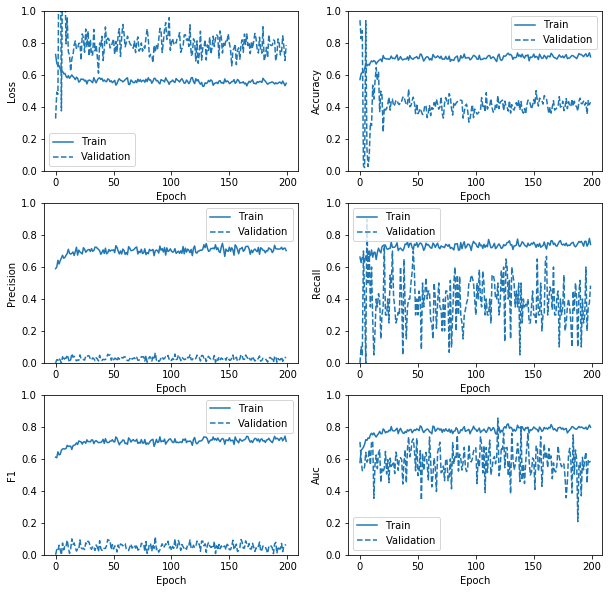

In [21]:
plt.figure(figsize=(10,10))
plot_metrics(up_history)

### Train with UP2 (1:10)

In [22]:
start = time.time()
up2_history = model.fit_generator(up2_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps,
                              class_weight=[0.5,1.5],
                              callbacks=[reduce_lr]
                             )
end = time.time()

Epoch 1/200
50/50 [==============================] - 22s 441ms/step - loss: 0.6837 - Accuracy: 0.5969 - Precision: 0.1706 - Recall: 0.7761 - F1: 0.2700 - AUC: 0.7915 - val_loss: 0.8243 - val_Accuracy: 0.3812 - val_Precision: 0.0555 - val_Recall: 0.6250 - val_F1: 0.0994 - val_AUC: 0.5095
Epoch 2/200
50/50 [==============================] - 21s 412ms/step - loss: 0.6499 - Accuracy: 0.6137 - Precision: 0.1582 - Recall: 0.8223 - F1: 0.2534 - AUC: 0.7994 - val_loss: 0.8547 - val_Accuracy: 0.3969 - val_Precision: 0.0356 - val_Recall: 0.5000 - val_F1: 0.0652 - val_AUC: 0.6910
Epoch 3/200
50/50 [==============================] - 20s 409ms/step - loss: 0.6216 - Accuracy: 0.6525 - Precision: 0.1867 - Recall: 0.8066 - F1: 0.2887 - AUC: 0.7888 - val_loss: 0.7848 - val_Accuracy: 0.3250 - val_Precision: 0.0227 - val_Recall: 0.4500 - val_F1: 0.0432 - val_AUC: 0.4323
Epoch 4/200
50/50 [==============================] - 21s 418ms/step - loss: 0.5914 - Accuracy: 0.6850 - Precision: 0.1874 - Recall: 0.74

50/50 [==============================] - 21s 411ms/step - loss: 0.3620 - Accuracy: 0.8806 - Precision: 0.3203 - Recall: 0.2637 - F1: 0.2569 - AUC: 0.7715 - val_loss: 0.5978 - val_Accuracy: 0.6812 - val_Precision: 0.0397 - val_Recall: 0.2500 - val_F1: 0.0682 - val_AUC: 0.4844
Epoch 30/200
50/50 [==============================] - 22s 433ms/step - loss: 0.3393 - Accuracy: 0.8988 - Precision: 0.3417 - Recall: 0.2623 - F1: 0.2718 - AUC: 0.8107 - val_loss: 0.5478 - val_Accuracy: 0.6406 - val_Precision: 0.0162 - val_Recall: 0.1500 - val_F1: 0.0287 - val_AUC: 0.6273
Epoch 31/200
50/50 [==============================] - 20s 401ms/step - loss: 0.3426 - Accuracy: 0.8888 - Precision: 0.3457 - Recall: 0.3580 - F1: 0.3138 - AUC: 0.8034 - val_loss: 0.6283 - val_Accuracy: 0.6344 - val_Precision: 0.0318 - val_Recall: 0.3500 - val_F1: 0.0579 - val_AUC: 0.6887
Epoch 32/200
50/50 [==============================] - 20s 405ms/step - loss: 0.3527 - Accuracy: 0.8838 - Precision: 0.3250 - Recall: 0.2213 - F1: 

50/50 [==============================] - 21s 416ms/step - loss: 0.2796 - Accuracy: 0.9056 - Precision: 0.0900 - Recall: 0.0300 - F1: 0.0447 - AUC: 0.8118 - val_loss: 0.4764 - val_Accuracy: 0.8375 - val_Precision: 0.0167 - val_Recall: 0.1000 - val_F1: 0.0286 - val_AUC: 0.5502
Epoch 58/200
50/50 [==============================] - 19s 390ms/step - loss: 0.2847 - Accuracy: 0.9038 - Precision: 0.1500 - Recall: 0.0612 - F1: 0.0778 - AUC: 0.7953 - val_loss: 0.4885 - val_Accuracy: 0.8406 - val_Precision: 0.0167 - val_Recall: 0.0500 - val_F1: 0.0250 - val_AUC: 0.6173
Epoch 59/200
50/50 [==============================] - 20s 405ms/step - loss: 0.2820 - Accuracy: 0.9131 - Precision: 0.2467 - Recall: 0.1187 - F1: 0.1444 - AUC: 0.7725 - val_loss: 0.4340 - val_Accuracy: 0.8375 - val_Precision: 0.1000 - val_Recall: 0.0500 - val_F1: 0.0667 - val_AUC: 0.5591
Epoch 60/200
50/50 [==============================] - 20s 405ms/step - loss: 0.2839 - Accuracy: 0.9056 - Precision: 0.1800 - Recall: 0.0570 - F1: 

Epoch 85/200
50/50 [==============================] - 20s 406ms/step - loss: 0.2955 - Accuracy: 0.8913 - Precision: 0.2200 - Recall: 0.0627 - F1: 0.0960 - AUC: 0.7976 - val_loss: 0.3252 - val_Accuracy: 0.9250 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5317
Epoch 86/200
50/50 [==============================] - 21s 414ms/step - loss: 0.2690 - Accuracy: 0.9094 - Precision: 0.1133 - Recall: 0.0707 - F1: 0.0814 - AUC: 0.7766 - val_loss: 0.3372 - val_Accuracy: 0.9281 - val_Precision: 0.0250 - val_Recall: 0.1000 - val_F1: 0.0400 - val_AUC: 0.5387
Epoch 87/200
50/50 [==============================] - 20s 403ms/step - loss: 0.2430 - Accuracy: 0.9200 - Precision: 0.0900 - Recall: 0.0467 - F1: 0.0570 - AUC: 0.8137 - val_loss: 0.4442 - val_Accuracy: 0.9500 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4773
Epoch 88/200
50/50 [==============================] - 20s 407ms/step - loss: 0.2498 - Accuracy: 0.9150 - Prec

50/50 [==============================] - 20s 398ms/step - loss: 0.2771 - Accuracy: 0.9006 - Precision: 0.0600 - Recall: 0.0167 - F1: 0.0260 - AUC: 0.7856 - val_loss: 0.3130 - val_Accuracy: 0.9563 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7135
Epoch 113/200
50/50 [==============================] - 21s 415ms/step - loss: 0.2443 - Accuracy: 0.9206 - Precision: 0.0600 - Recall: 0.0173 - F1: 0.0267 - AUC: 0.7831 - val_loss: 0.2691 - val_Accuracy: 0.9531 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6070
Epoch 114/200
50/50 [==============================] - 20s 396ms/step - loss: 0.2477 - Accuracy: 0.9137 - Precision: 0.0200 - Recall: 0.0040 - F1: 0.0067 - AUC: 0.8012 - val_loss: 0.3249 - val_Accuracy: 0.9563 - val_Precision: 0.0500 - val_Recall: 0.1000 - val_F1: 0.0667 - val_AUC: 0.7021
Epoch 115/200
50/50 [==============================] - 20s 397ms/step - loss: 0.2711 - Accuracy: 0.9081 - Precision: 0.0

50/50 [==============================] - 21s 420ms/step - loss: 0.2842 - Accuracy: 0.8938 - Precision: 0.1000 - Recall: 0.0295 - F1: 0.0443 - AUC: 0.8061 - val_loss: 0.2526 - val_Accuracy: 0.9844 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7595
Epoch 140/200
50/50 [==============================] - 21s 410ms/step - loss: 0.2553 - Accuracy: 0.9119 - Precision: 0.0800 - Recall: 0.0400 - F1: 0.0490 - AUC: 0.7766 - val_loss: 0.2543 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4746
Epoch 141/200
50/50 [==============================] - 20s 401ms/step - loss: 0.2723 - Accuracy: 0.9013 - Precision: 0.0700 - Recall: 0.0207 - F1: 0.0314 - AUC: 0.8110 - val_loss: 0.3359 - val_Accuracy: 0.9625 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5589
Epoch 142/200
50/50 [==============================] - 20s 405ms/step - loss: 0.2622 - Accuracy: 0.9087 - Pr

50/50 [==============================] - 21s 429ms/step - loss: 0.2472 - Accuracy: 0.9131 - Precision: 0.0200 - Recall: 0.0067 - F1: 0.0100 - AUC: 0.8089 - val_loss: 0.3700 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4467
Epoch 167/200
50/50 [==============================] - 19s 386ms/step - loss: 0.2880 - Accuracy: 0.8950 - Precision: 0.0400 - Recall: 0.0100 - F1: 0.0157 - AUC: 0.7857 - val_loss: 0.2835 - val_Accuracy: 0.9625 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5659
Epoch 168/200
50/50 [==============================] - 20s 407ms/step - loss: 0.2711 - Accuracy: 0.9031 - Precision: 0.0800 - Recall: 0.0215 - F1: 0.0324 - AUC: 0.7917 - val_loss: 0.2716 - val_Accuracy: 0.9656 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6595
Epoch 169/200
50/50 [==============================] - 28s 570ms/step - loss: 0.2439 - Accuracy: 0.9112 - Pr

50/50 [==============================] - 28s 556ms/step - loss: 0.2574 - Accuracy: 0.9106 - Precision: 0.1200 - Recall: 0.0435 - F1: 0.0617 - AUC: 0.7930 - val_loss: 0.2367 - val_Accuracy: 0.9719 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5643
Epoch 194/200
50/50 [==============================] - 28s 566ms/step - loss: 0.2392 - Accuracy: 0.9150 - Precision: 0.0800 - Recall: 0.0390 - F1: 0.0480 - AUC: 0.8287 - val_loss: 0.2506 - val_Accuracy: 0.9844 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6735
Epoch 195/200
50/50 [==============================] - 24s 485ms/step - loss: 0.2576 - Accuracy: 0.9050 - Precision: 0.0200 - Recall: 0.0100 - F1: 0.0133 - AUC: 0.8099 - val_loss: 0.2402 - val_Accuracy: 0.9719 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4859
Epoch 196/200
50/50 [==============================] - 23s 467ms/step - loss: 0.2319 - Accuracy: 0.9225 - Pr

In [23]:
print("Time taken:",end-start)

Time taken: 4329.461934328079


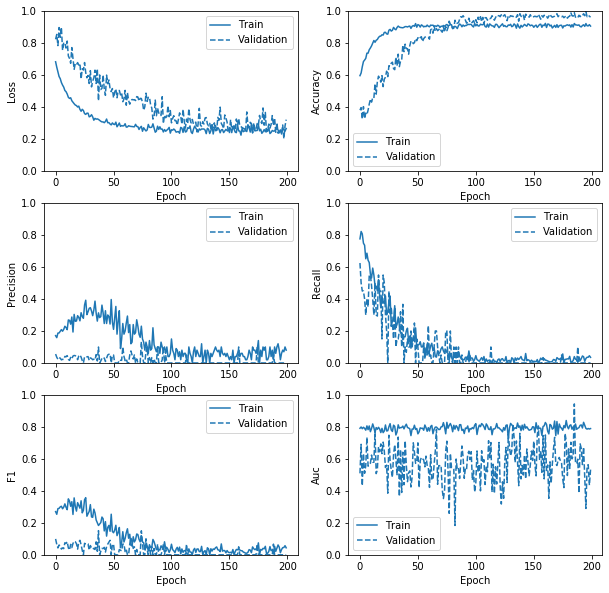

In [24]:
plt.figure(figsize=(10,10))
plot_metrics(up2_history)

### Train with UP3 (1:20)

In [25]:
start = time.time()
up3_history = model.fit_generator(up3_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps,
                              class_weight=[0.3,1.8],
                              callbacks=[reduce_lr]
                             )
end = time.time()

Epoch 1/200
50/50 [==============================] - 25s 492ms/step - loss: 0.1703 - Accuracy: 0.9550 - Precision: 0.0500 - Recall: 0.0150 - F1: 0.0227 - AUC: 0.8148 - val_loss: 0.2775 - val_Accuracy: 0.9781 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6295
Epoch 2/200
50/50 [==============================] - 23s 457ms/step - loss: 0.1706 - Accuracy: 0.9538 - Precision: 0.0800 - Recall: 0.0500 - F1: 0.0593 - AUC: 0.8322 - val_loss: 0.2692 - val_Accuracy: 0.9594 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5809
Epoch 3/200
50/50 [==============================] - 24s 476ms/step - loss: 0.1718 - Accuracy: 0.9550 - Precision: 0.0400 - Recall: 0.0167 - F1: 0.0233 - AUC: 0.8018 - val_loss: 0.2571 - val_Accuracy: 0.9781 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5397
Epoch 4/200
50/50 [==============================] - 22s 434ms/step - loss: 0.1783 - Accuracy: 0.946

50/50 [==============================] - 20s 406ms/step - loss: 0.1545 - Accuracy: 0.9581 - Precision: 0.0200 - Recall: 0.0050 - F1: 0.0080 - AUC: 0.8138 - val_loss: 0.2060 - val_Accuracy: 0.9719 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7449
Epoch 29/200
50/50 [==============================] - 20s 407ms/step - loss: 0.1631 - Accuracy: 0.9544 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8050 - val_loss: 0.1947 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5884
Epoch 30/200
50/50 [==============================] - 20s 399ms/step - loss: 0.1679 - Accuracy: 0.9475 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8456 - val_loss: 0.3116 - val_Accuracy: 0.9719 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6404
Epoch 31/200
50/50 [==============================] - 20s 396ms/step - loss: 0.1666 - 

50/50 [==============================] - 20s 390ms/step - loss: 0.1606 - Accuracy: 0.9563 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7660 - val_loss: 0.1517 - val_Accuracy: 0.9812 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4843
Epoch 55/200
50/50 [==============================] - 20s 395ms/step - loss: 0.1468 - Accuracy: 0.9606 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7849 - val_loss: 0.2209 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7708
Epoch 56/200
50/50 [==============================] - 21s 418ms/step - loss: 0.1709 - Accuracy: 0.9506 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7725 - val_loss: 0.1241 - val_Accuracy: 0.9781 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4831
Epoch 57/200
50/50 [==============================] - 19s 376ms/step - los

50/50 [==============================] - 21s 417ms/step - loss: 0.1834 - Accuracy: 0.9444 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8031 - val_loss: 0.1935 - val_Accuracy: 0.9937 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.8506
Epoch 81/200
50/50 [==============================] - 20s 396ms/step - loss: 0.1562 - Accuracy: 0.9550 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8146 - val_loss: 0.2511 - val_Accuracy: 0.9625 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5809
Epoch 82/200
50/50 [==============================] - 20s 408ms/step - loss: 0.1728 - Accuracy: 0.9469 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8081 - val_loss: 0.1209 - val_Accuracy: 0.9750 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5539
Epoch 83/200
50/50 [==============================] - 21s 418ms/step - los

50/50 [==============================] - 20s 391ms/step - loss: 0.1586 - Accuracy: 0.9550 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7785 - val_loss: 0.1733 - val_Accuracy: 0.9563 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6625
Epoch 107/200
50/50 [==============================] - 22s 434ms/step - loss: 0.1791 - Accuracy: 0.9444 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8177 - val_loss: 0.2149 - val_Accuracy: 0.9839 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.4778
Epoch 108/200
50/50 [==============================] - 18s 361ms/step - loss: 0.1575 - Accuracy: 0.9531 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8172 - val_loss: 0.2165 - val_Accuracy: 0.9812 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7290
Epoch 109/200
50/50 [==============================] - 20s 394ms/step - 

50/50 [==============================] - 20s 404ms/step - loss: 0.1752 - Accuracy: 0.9494 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7660 - val_loss: 0.2496 - val_Accuracy: 0.9937 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.3679
Epoch 133/200
50/50 [==============================] - 20s 410ms/step - loss: 0.1451 - Accuracy: 0.9588 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8060 - val_loss: 0.1855 - val_Accuracy: 0.9750 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6270
Epoch 134/200
50/50 [==============================] - 21s 411ms/step - loss: 0.1750 - Accuracy: 0.9438 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8467 - val_loss: 0.1488 - val_Accuracy: 0.9750 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6018
Epoch 135/200
50/50 [==============================] - 20s 405ms/step - 

50/50 [==============================] - 20s 410ms/step - loss: 0.1578 - Accuracy: 0.9531 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8077 - val_loss: 0.1874 - val_Accuracy: 0.9906 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5126
Epoch 159/200
50/50 [==============================] - 21s 411ms/step - loss: 0.1697 - Accuracy: 0.9494 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.8004 - val_loss: 0.2637 - val_Accuracy: 0.9688 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6658
Epoch 160/200
50/50 [==============================] - 21s 412ms/step - loss: 0.1614 - Accuracy: 0.9531 - Precision: 0.0200 - Recall: 0.0100 - F1: 0.0133 - AUC: 0.7932 - val_loss: 0.2880 - val_Accuracy: 0.9781 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.6050
Epoch 161/200
50/50 [==============================] - 20s 401ms/step - loss: 0.1555

50/50 [==============================] - 21s 414ms/step - loss: 0.1486 - Accuracy: 0.9581 - Precision: 0.0400 - Recall: 0.0107 - F1: 0.0167 - AUC: 0.8266 - val_loss: 0.2735 - val_Accuracy: 0.9750 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5849
Epoch 185/200
50/50 [==============================] - 19s 376ms/step - loss: 0.1575 - Accuracy: 0.9569 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - F1: 0.0000e+00 - AUC: 0.7526 - val_loss: 0.1584 - val_Accuracy: 0.9719 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.5727
Epoch 186/200
50/50 [==============================] - 20s 399ms/step - loss: 0.1595 - Accuracy: 0.9513 - Precision: 0.0200 - Recall: 0.0100 - F1: 0.0133 - AUC: 0.8319 - val_loss: 0.2097 - val_Accuracy: 0.9781 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.7613
Epoch 187/200
50/50 [==============================] - 20s 397ms/step - loss: 0.1356 - Accuracy:

In [26]:
print("Time taken:",end-start)

Time taken: 4062.5586121082306


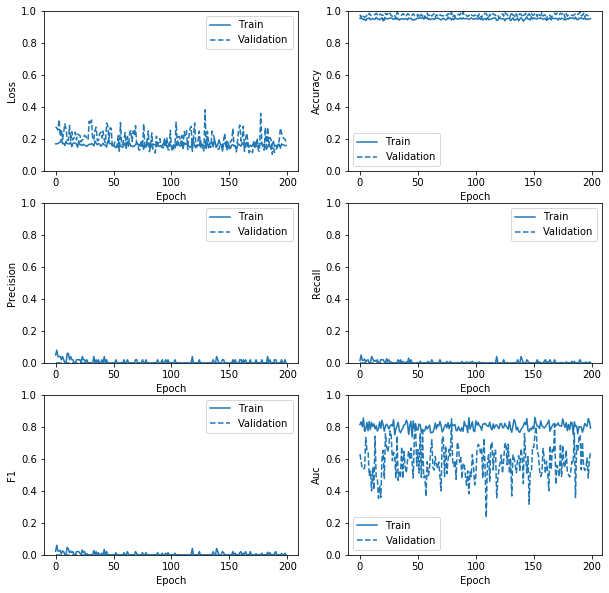

In [27]:
plt.figure(figsize=(10,10))
plot_metrics(up3_history)

### Train with UP4 (1:30)

In [28]:
# start = time.time()
# up4_history = model.fit_generator(up4_train_generator, 
#                               epochs=n_epochs, 
#                               steps_per_epoch=n_steps_per_epoch,
#                               validation_data=validation_generator,
#                               validation_steps=n_validation_steps, 
#                               callbacks=[reduce_lr]
#                              )
# end = time.time()

In [29]:
# print("Time taken:",end-start)

In [30]:
# plt.figure(figsize=(10,10))
# plot_metrics(up4_history)

### Train with Imbalanced original train data (1:40)

In [31]:
# start = time.time()
# imb_history = model.fit_generator(imb_train_generator,
#                                   epochs=n_epochs,
#                                   steps_per_epoch=n_steps_per_epoch,
#                                   validation_data=validation_generator,
#                                   validation_steps=n_validation_steps,
#                                   class_weight = class_weight,
#                                   callbacks=[reduce_lr]
#                                  )
# end = time.time()

In [32]:
# print("Time taken:",end-start)

In [33]:
# plt.figure(figsize=(10,10))
# plot_metrics(imb_history)

## Evaluation

In [34]:
results_tr = model.evaluate(imb_train_generator,steps=100)
results_vl = model.evaluate(validation_generator,steps=100)

100/100 [==============================] - 19s 185ms/step


In [35]:
print("NAME :\tTRAIN :\tVALIDATION ")
for name, value_tr, value_vl in zip(model.metrics_names, results_tr, results_vl):
    print("%s : %5.3f : %7.3f" %(name, value_tr , value_vl))

# without classweights:
# NAME :	TRAIN :	VALIDATION 
# loss : 0.754 :   0.465
# Accuracy : 0.531 :   0.866
# Precision : 0.006 :   0.006
# Recall : 0.070 :   0.040
# F1 : 0.011 :   0.010
# AUC : 0.565 :   0.544

NAME :	TRAIN :	VALIDATION 
loss : 0.295 :   0.116
Accuracy : 0.974 :   0.978
Precision : 0.010 :   0.000
Recall : 0.003 :   0.000
F1 : 0.005 :   0.000
AUC : 0.633 :   0.588


## Prediction
The output of a binary classification is the probability of a sample belonging to a class.

In [36]:
# PREDICTED LABELS
start = time.time()
pred_tr = model.predict(imb_train_generator)
tr_end = time.time()
pred_vl = model.predict(validation_generator)
vl_end = time.time()

tr_end-start , vl_end-tr_end

(1231.1344616413116, 178.64071774482727)

In [ ]:
# np.save(funduspath_CR + str(n_epochs) + 'ep_traintwice_newtr.npy', pred_tr)
# np.save(funduspath_CR + str(n_epochs) + 'ep_traintwice_newvl.npy', pred_vl)

In [38]:
# val_class = []
# for i, predicted in enumerate(pred_vl):
#     if predicted[0] > 0.1:
#         #assign i to class 1
#         val_class.append(1)
#     else:
#         #assign i to class 0
#         val_class.append(0)

In [39]:
# TRUE LABELS

train_labels = valid_traindf_names[Class].tolist()
train_labels = [int(i) for i in train_labels]

val_labels = valid_valdf_names[Class].tolist()
val_labels = [int(i) for i in val_labels]


### ROC Curve

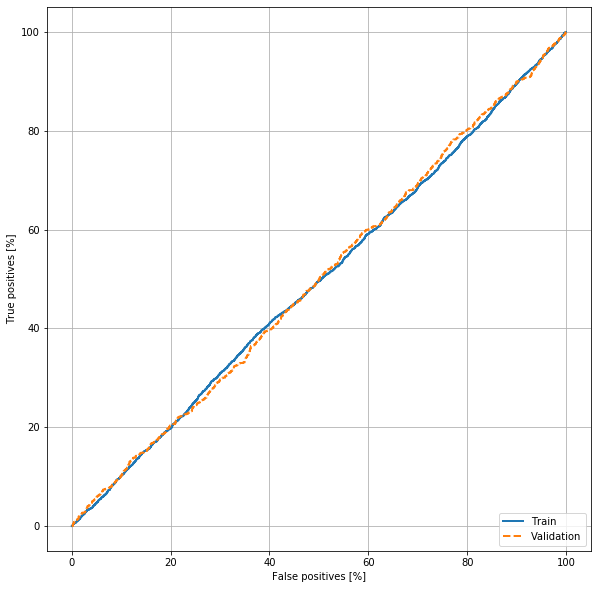

In [40]:
plt.figure(figsize=(10,10))
plot_roc("Train", train_labels, pred_tr, color=colors[0])
plot_roc("Validation", val_labels, pred_vl, color=colors[1],linestyle='--')
# plot_roc("Validation", val_labels, val_class, color=colors[3],linestyle='-.') # theshold 0.1
plt.legend(loc='lower right')

### Confusion matrix

Train data: 
TN: 99243 
FP: 212 
FN: 2372 
TP: 7
Healthy Patients - correctly identified (True Negatives):  99243 0.9978683826856367
Healthy Patients - predicted to have glaucoma (False Positives):  212 0.00213161731436328
Glaucoma Patients - predicted healthy (False Negatives):  2372 0.9970575872215216
Glaucoma Patients - correctly identified (True Positives):  7 0.0029424127784783522

Total Glaucoma patients:  2379 1.0
Total Healthy patients:  99455 1.0


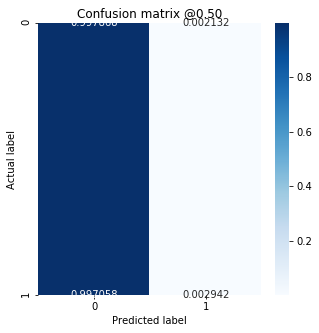

In [41]:
tn, fp, fn, tp = confusion_matrix(train_labels, pred_tr > 0.5).ravel()
train_cm = [tn, fp, fn, tp]
print("Train data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(train_labels, pred_tr)

Validation data: 
TN: 33133 
FP: 1 
FN: 809 
TP: 0
Healthy Patients - correctly identified (True Negatives):  33133 0.9999698195207339
Healthy Patients - predicted to have glaucoma (False Positives):  1 3.0180479266010744e-05
Glaucoma Patients - predicted healthy (False Negatives):  809 1.0
Glaucoma Patients - correctly identified (True Positives):  0 0.0

Total Glaucoma patients:  809 1.0
Total Healthy patients:  33134 1.0


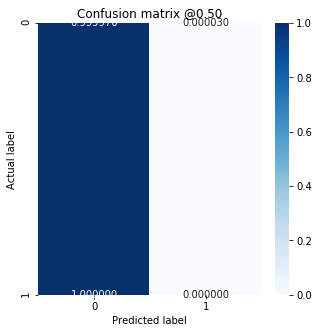

In [42]:
tn, fp, fn, tp = confusion_matrix(val_labels, pred_vl > 0.5).ravel()
val_cm = [tn, fp, fn, tp]
print("Validation data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(val_labels, pred_vl)

### MLFlow 

In [48]:
# history = up3_history
# tag_value = "trained twice bal and 1:10 and 1:20 with 78 tr layers and cw 0.5:1.5 and 0.3:1.8"

# exp_name = get_notebook_name()+"-run at-"+datetime.datetime.now().strftime("%d%b%Y %H:%M")
# keras_model_path = funduspath_CR+ exp_name + '_model'
# save_mlflow(keras_model_path,exp_name,which_gt,which_model,seq,BATCH_SIZE,
#             n_epochs,n_steps_per_epoch,n_validation_steps,
#             reg_value,learning_rate,decay,opt,
#             history,results_tr,results_vl,train_cm,val_cm
#            )

<IPython.core.display.Javascript object>

In [49]:
# client = MlflowClient()
# run = client.create_run('19')
# client.set_tag(run.info.run_id, "tag_key", tag_value)